## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

## Define directory of images

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/201912_gm6001/' #master folder

## Make dictionary for storing results

In [35]:
results = {"filename":[],"exp":[],"coverslip":[],
           "Manual mask from matlab GUI":[],"bg sub int under mask":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(fileli'st)):
    #if "analyse" in str(filelist[i]):
        if filelist[i].endswith(".nd2"): 
            results["filename"].append(filelist[i])
            results["coverslip"].append(filelist[i].split('/')[-2])
            results["exp"].append(filelist[i].split('/')[-5])

## Read manual masks from Matlab GUI

In [36]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_dendritesmask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analysis of images - mean intensity

In [37]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[0]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    #read masks 
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #image after background subtraction
    #for ecm image
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
        
    if flag==True:
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
    else:
        results["bg sub int under mask"].append(np.nan)

Total number of images: 240
Calculating image no 1 out of240
Calculating image no 2 out of240
Calculating image no 3 out of240
Calculating image no 4 out of240
Calculating image no 5 out of240
Calculating image no 6 out of240
Calculating image no 7 out of240
Calculating image no 8 out of240
Calculating image no 9 out of240
Calculating image no 10 out of240
Calculating image no 11 out of240
Calculating image no 12 out of240
Calculating image no 13 out of240
Calculating image no 14 out of240
Calculating image no 15 out of240
Calculating image no 16 out of240
Calculating image no 17 out of240
Calculating image no 18 out of240
Calculating image no 19 out of240
Calculating image no 20 out of240
Calculating image no 21 out of240
Calculating image no 22 out of240
Calculating image no 23 out of240
Calculating image no 24 out of240
Calculating image no 25 out of240
Calculating image no 26 out of240
Calculating image no 27 out of240
Calculating image no 28 out of240
Calculating image no 29 out o

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.


Calculating image no 194 out of240
Calculating image no 195 out of240
Calculating image no 196 out of240
Calculating image no 197 out of240
Calculating image no 198 out of240
Calculating image no 199 out of240
Calculating image no 200 out of240
Calculating image no 201 out of240
Calculating image no 202 out of240
Calculating image no 203 out of240
Calculating image no 204 out of240
Calculating image no 205 out of240
Calculating image no 206 out of240
Calculating image no 207 out of240
Calculating image no 208 out of240
Calculating image no 209 out of240
Calculating image no 210 out of240
Calculating image no 211 out of240
Calculating image no 212 out of240
Calculating image no 213 out of240
Calculating image no 214 out of240
Calculating image no 215 out of240
Calculating image no 216 out of240
Calculating image no 217 out of240
Calculating image no 218 out of240
Calculating image no 219 out of240
Calculating image no 220 out of240
Calculating image no 221 out of240
Calculating image no

## Make a dataframe of the results

In [94]:
df=pd.DataFrame(results)
df2=deepcopy(df)
df2['Blocked or not']='None'
df2.loc[df2['filename'].str.contains('blocked'), 'Blocked or not'] = 'Blocked'
df2.loc[df2['filename'].str.contains('blk'), 'Blocked or not'] = 'Blocked'
df2.loc[df2['filename'].str.contains('unblocked'), 'Blocked or not'] = 'Unblocked'
df2.loc[df2['filename'].str.contains('unblk'), 'Blocked or not'] = 'Unblocked'

df2['Drug']='None'


df2.loc[df2['filename'].str.contains('gm6001_1to250'), 'Drug'] = 'GM6001'
df2.loc[df2['filename'].str.contains('gm6001_1to100'), 'Drug'] = 'GM6001'
df2.loc[df2['filename'].str.contains('gm60011to100'), 'Drug'] = 'GM6001'
df2.loc[df2['filename'].str.contains('dmso_1to250'), 'Drug'] = 'DMSO'
df2.loc[df2['filename'].str.contains('dmso_1to100'), 'Drug'] = 'DMSO'
df2.loc[df2['filename'].str.contains('dmso1to100'), 'Drug'] = 'DMSO'

df2['Treatment']='None'


df2.loc[df2['filename'].str.contains('gm6001_1to250'), 'Treatment'] = 'GM6001 1:250'
df2.loc[df2['filename'].str.contains('gm6001_1to100'), 'Treatment'] = 'GM6001 1:100'
df2.loc[df2['filename'].str.contains('gm60011to100'), 'Treatment'] = 'GM6001 1:100'
df2.loc[df2['filename'].str.contains('dmso_1to250'), 'Treatment'] = 'DMSO 1:250'
df2.loc[df2['filename'].str.contains('dmso_1to100'), 'Treatment'] = 'DMSO 1:100'
df2.loc[df2['filename'].str.contains('dmso1to100'), 'Treatment'] = 'DMSO 1:100'

## Add intensity normd to med of experiment

In [96]:
df2["ecm mean int norm2med"]=df2["bg sub int under mask"]
expnam=[]
medtnr=[]
for exp in df2["exp"].unique():
    dfexp=df2[df2["exp"]==exp]
    med_tnr=dfexp["bg sub int under mask"].median()
    expnam.append(exp)
    medtnr.append(med_tnr)
df2["ecm mean int norm2med"]=np.nan
df2["syt mean int norm2med"]=np.nan
for i in range(0,len(df2)):
    if df2["exp"][i]==expnam[0]:
        df2["ecm mean int norm2med"][i]=df2["bg sub int under mask"][i]/medtnr[0]
    if df2["exp"][i]==expnam[1]:
        df2["ecm mean int norm2med"][i]=df2["bg sub int under mask"][i]/medtnr[1]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Barplot

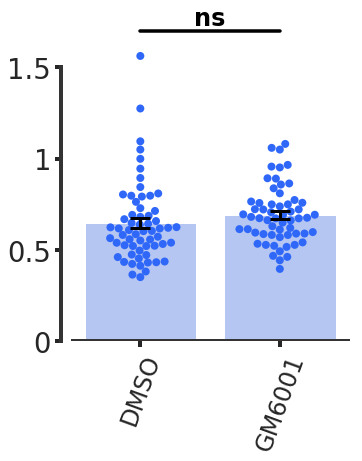

In [106]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(5,6))

df2plot=df2[df2["Blocked or not"]=="Blocked"]
#var="bg sub int under mask"
var="ecm mean int norm2med"


order=['DMSO',
       'GM6001'
       ]

'''paletteswarm ={"Background - Autofluorescence":"#2F67F8",
               "Unblocked TNR647":"#333333",
               "Background - Atto647":"#2F67F8",
               "Block+0, TNR647":"#2F67F8",
               "Block+12, TNR647":"#2F67F8"}
palette ={"Background - Autofluorescence":"#abc2fc",
          "Unblocked TNR647":"#adadad",
               "Background - Atto647":"#abc2fc",
               "Block+0, TNR647":"#abc2fc",
               "Block+12, TNR647":"#abc2fc"}'''


g=sns.barplot(data=df2plot,y=var,x="Drug"
            ,order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Drug"
            ,order=order,color="#2F67F8",size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Drug"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Drug"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),['DMSO','GM6001'],
           rotation=70,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
#plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')


scale_x=1
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

#plt.ylim([0,12.5])
x1, x2 = 0,1
y= 1.7
h=0.001
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')



diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp1_fixedctrl.svg', bbox_inches='tight', format='svg')












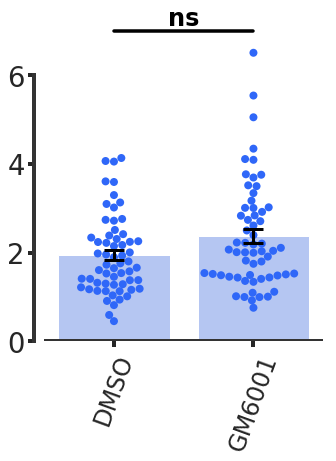

In [115]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(5,6))

df2plot=df2[df2["Blocked or not"]=="Unblocked"]
#var="bg sub int under mask"
var="ecm mean int norm2med"


order=['DMSO',
       'GM6001'
       ]

'''paletteswarm ={"Background - Autofluorescence":"#2F67F8",
               "Unblocked TNR647":"#333333",
               "Background - Atto647":"#2F67F8",
               "Block+0, TNR647":"#2F67F8",
               "Block+12, TNR647":"#2F67F8"}
palette ={"Background - Autofluorescence":"#abc2fc",
          "Unblocked TNR647":"#adadad",
               "Background - Atto647":"#abc2fc",
               "Block+0, TNR647":"#abc2fc",
               "Block+12, TNR647":"#abc2fc"}'''


g=sns.barplot(data=df2plot,y=var,x="Drug"
            ,order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Drug"
            ,order=order,color="#2F67F8",size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Drug"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Drug"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),['DMSO','GM6001'],
           rotation=70,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
#plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')


scale_x=1
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

#plt.ylim([0,12.5])
x1, x2 = 0,1
y= 7
h=0.001
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')



diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp1_fixedctrl.svg', bbox_inches='tight', format='svg')

In [111]:
dfblocked=df2[df2["Blocked or not"]=="Blocked"]
dfblocked=dfblocked.reset_index()
with ND2Reader(dfblocked["filename"][1]) as images:
    ecm_image=images[0]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_imag_blockede=ecm_image.astype(np.int16)
dfunblocked=df2[df2["Blocked or not"]=="Unblocked"]
dfunblocked=dfunblocked.reset_index()
with ND2Reader(dfunblocked["filename"][1]) as images:
    ecm_image=images[0]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_imag_unblockede=ecm_image.astype(np.int16)

In [112]:
unblocked_dmso=dfunblocked[dfunblocked["Drug"]=="DMSO"][var].dropna()
unblocked_gm6=dfunblocked[dfunblocked["Drug"]=="GM6001"][var].dropna()

[stat, pval]=stats.ttest_ind(unblocked_dmso,unblocked_gm6)

pval

0.025277337895483507

In [113]:
blocked_dmso=dfblocked[dfblocked["Drug"]=="DMSO"][var].dropna()
blocked_gm6=dfblocked[dfblocked["Drug"]=="GM6001"][var].dropna()

[stat, pval]=stats.ttest_ind(blocked_dmso,blocked_gm6)

pval

0.21657281750612115

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

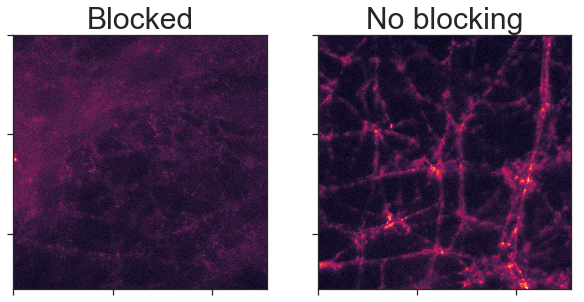

In [47]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(121)
plt.imshow(ecm_imag_blockede,vmin=np.min(ecm_imag_blockede),vmax=np.max(ecm_imag_unblockede))
plt.title('Blocked')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
fig.add_subplot(122)
plt.imshow(ecm_imag_unblockede,vmin=np.min(ecm_imag_blockede),vmax=np.max(ecm_imag_unblockede))
plt.title('No blocking')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)